# Benchmarking_v5

This notebook contains code for the Customer Benchmarking Solution as developed by CMU's capstone team for 71lbs.<br>
The code structure is outlined below:

1. Import relevant packages
2. Read in the input pickle file
3. Pre-Process data for Benchmarking:
    - Extract relevant attributes from input dataframe
    - Create pivot tables for shipment volume, weight and their respective zone-wise proportions
    - Calculate the indices required as input for the Similarity Score calculation. These include:<br>
    i. `Volumetric Scale Index (VSI)`: Quantifies customer similarity through total shipment volume<br>
    ii.`Volumetric Distribution Index (VDI)`: Quantifies customer similarity through zone-wise volume distribution<br>
    iii.`Weight Scale Index (WSI)`: Quantifies customer similarity through total shipment weight<br>
    iv. `Weight Distribution Index (WDI)`: Quantifies customer similarity through zone-wise weight distribution
4. Calculate Similarity Scores
5. Create Similarity Score Matrix
6. Identify Similar Customers
7. Calculate and display relevant KPIs

## 1. Import Relevant Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox as bc
from scipy.stats import skew
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

## 2. Read in the input pickle file

In [2]:
print(os.getcwd())

pickle_dir = os.getcwd()+ "\\Benchmarking\\test_merged_sample.pickle"
#pickle_dir = os.getcwd()+ "\\Benchmarking\\test_merged_190715_half.pickle"
#pickle_dir = os.getcwd()+ "\\Benchmarking\\test_merged_full.pickle"
print("Reading pickle file from", pickle_dir)

raw_df = pd.DataFrame()
raw_df = pd.read_pickle(pickle_dir)#test_merged_sample.pickle")
print("Initial pickle contains", len(raw_df.index), "records")

C:\Users\Shivalik\Desktop\CMU\M19\Capstone
Reading pickle file from C:\Users\Shivalik\Desktop\CMU\M19\Capstone\Benchmarking\test_merged_sample.pickle
Initial pickle contains 914372 records


## 3. Pre-process data for Benchmarking

### Extract relevant attributes from input dataframe

In [ ]:
#Count the number of unique business_sids in the input dataframe
business_sid_list = raw_df.iloc[:,1].unique()
total_customers_in_data = len(business_sid_list)
print("There are" , total_customers_in_data , "unique customers in the dataset")

#Extract business_sid, shipment weight and zone to use for the benchmarking algorithm
benchmarking_df = raw_df[['business_sid', 'weight', 'zone']]
benchmarking_df.iloc[:,2] = benchmarking_df.iloc[:,2].astype('int64').astype('category') 
benchmarking_df.head()

#Optional code below - to free up memory
#del raw_df

### Create pivot tables for shipment volume, weight and their respective zone-wise proportions

In [19]:
#Create pivot table for volume counts
def create_volumeCount_pivotTable(arg_df):
    tempvoldf = arg_df.groupby(['business_sid', 'zone']).count()
    tempvoldf.columns = ['Count']
    volumeCount_pivotTable = pd.pivot_table(tempvoldf, values = 'Count', index = ['business_sid'], columns = 'zone', 
                     aggfunc = np.sum, fill_value = 0)
    if len(volumeCount_pivotTable)!=total_customers_in_data:
        print("Pivot table created for a subset of all customer IDs")
    return volumeCount_pivotTable
####################################################################################################################    
#Create pivot table for volume proportions
def create_volumeProportion_pivotTable(arg_df):
    volumeProportion_pivotTable = arg_df.apply(lambda x: x/x.sum(), axis = 1)
    if len(volumeProportion_pivotTable)!=total_customers_in_data:
        print("Pivot table created for a subset of all customer IDs")
    return volumeProportion_pivotTable
####################################################################################################################
#Create pivot table for weight counts   
def create_weightCount_pivotTable(arg_df):
    tempwtdf = arg_df.groupby(['business_sid', 'zone']).sum()
    weightSum_pivotTable = pd.pivot_table(tempwtdf, values = 'weight', index = ['business_sid'], columns = 'zone',
                                         aggfunc = np.sum, fill_value = 0)
    if len(weightSum_pivotTable)!=total_customers_in_data:
        print("Pivot table created for a subset of all customer IDs")
    return weightSum_pivotTable
####################################################################################################################    
#Create pivot table for weight proportions
def create_weightProportion_pivotTable(arg_df):
    weightProportion_pivotTable= arg_df.apply(lambda x: x/x.sum(), axis = 1)
    if len(weightProportion_pivotTable)!=total_customers_in_data:
        print("Pivot table created for a subset of all customer IDs")
    return weightProportion_pivotTable
####################################################################################################################    
#Combine all pivot tables under a single function
#This will come in handy later while calculating similarity scores
def create_PivotTables(arg_df):
    a = create_volumeCount_pivotTable(arg_df)
    b = create_volumeProportion_pivotTable(a)
    c = create_weightCount_pivotTable(arg_df)
    d = create_weightProportion_pivotTable(c)
    return a,b,c,d   

In [ ]:
#Sample code for testing
'''
vc_table_test = create_volumeCount_pivotTable(benchmarking_df)
vc_table_test.head()

vp_table_test = create_volumeProportion_pivotTable(vc_table_test)
vp_table_test.head()

wc_table_test = create_weightCount_pivotTable(benchmarking_df)
wc_table_test.head()

wp_table_test = create_weightProportion_pivotTable(wc_table_test)
wp_table_test.head()
'''

In [ ]:
#These table outputs are just a sample for testing
vsitestingdf = vc_table_test.head()
vditestingdf = vp_table_test.head()
wsitestingdf = wc_table_test.head()
wditestingdf = wp_table_test.head()

In [ ]:
vsitestingdf

In [ ]:
vditestingdf

In [ ]:
wsitestingdf

In [ ]:
wditestingdf

### Calculate the indices required as input for the Similarity Score calculation

In [ ]:
def calculate_VSI(sid_in_focus, vsiPivotTable, sid_count, sid_list):
    #sid_list = vsiPivotTable.index.values
    #sid_count = len(sid_list)
    vsi_list = np.empty(sid_count)
    sid_in_focus_arr = np.array(vsiPivotTable.loc[sid_in_focus])
    comparison_arr = np.array(vsiPivotTable)
    for x in range(sid_count):
        if(sid_list[x]!=sid_in_focus):
            #code for v3
            vsi_numerator = np.minimum(sid_in_focus_arr,comparison_arr[x]).sum()
            vsi_denominator = np.maximum(sid_in_focus_arr,comparison_arr[x]).sum()
            
            #code for v2
            #vsi_numerator = np.minimum(np.array(vsiPivotTable.loc[sid_in_focus]),np.array(vsiPivotTable.iloc[x])).sum()
            #vsi_denominator = np.maximum(np.array(vsiPivotTable.loc[sid_in_focus]),np.array(vsiPivotTable.iloc[x])).sum()
         
            #code for v1
            #vsi_numerator = vsiPivotTable.loc[sid_in_focus].combine(vsiPivotTable.iloc[x], min, 0)
            #vsi_denominator = vsiPivotTable.loc[sid_in_focus].combine(vsiPivotTable.iloc[x], max, 0)
            #vsi_list[x] = vsi_numerator.sum()/vsi_denominator.sum()
            
            vsi_list[x] = vsi_numerator/vsi_denominator
        else:
            vsi_list[x] = -1  # return a value of -1 when comparing a customer to themselves        
    return vsi_list
####################################################################################################################    
def calculate_VDI(sid_in_focus, vdiPivotTable, sid_count, sid_list):
    #sid_list = vdiPivotTable.index.values
    #sid_count = len(sid_list)
    vdi_list = np.empty(sid_count)
    sid_in_focus_arr = np.array(vdiPivotTable.loc[sid_in_focus])
    comparison_arr = np.array(vdiPivotTable)
    for x in range(sid_count):
        if(sid_list[x]!=sid_in_focus):
            #code for v3
            vdi_numerator = np.minimum(sid_in_focus_arr,comparison_arr[x]).sum()
            vdi_denominator = np.maximum(sid_in_focus_arr,comparison_arr[x]).sum()
            
            #code for v2
            #vdi_numerator = np.minimum(np.array(vdiPivotTable.loc[sid_in_focus]),np.array(vdiPivotTable.iloc[x])).sum()
            #vdi_denominator = np.maximum(np.array(vdiPivotTable.loc[sid_in_focus]),np.array(vdiPivotTable.iloc[x])).sum()
            
            #code for v1
            #vdi_numerator = vdiPivotTable.loc[sid_in_focus].combine(vdiPivotTable.iloc[x], min, 0)
            #vdi_denominator = vdiPivotTable.loc[sid_in_focus].combine(vdiPivotTable.iloc[x], max, 0)
            vdi_list[x] = vdi_numerator/vdi_denominator
        else:
            vdi_list[x] = -1  # return a value of -1 when comparing a customer to themselves                
    return vdi_list
####################################################################################################################    
def calculate_WSI(sid_in_focus, wsiPivotTable, sid_count, sid_list):
    #sid_list = wsiPivotTable.index.values
    #sid_count = len(sid_list)
    wsi_list = np.empty(sid_count)
    sid_in_focus_arr = np.array(wsiPivotTable.loc[sid_in_focus])
    comparison_arr = np.array(wsiPivotTable)
    for x in range(sid_count):
        if(sid_list[x]!=sid_in_focus):
            #code for v3
            wsi_numerator = np.minimum(sid_in_focus_arr,comparison_arr[x]).sum()
            wsi_denominator = np.maximum(sid_in_focus_arr,comparison_arr[x]).sum()
            
            #code for v2
            #wsi_numerator = np.minimum(np.array(wsiPivotTable.loc[sid_in_focus]),np.array(wsiPivotTable.iloc[x])).sum()
            #wsi_denominator = np.maximum(np.array(wsiPivotTable.loc[sid_in_focus]),np.array(wsiPivotTable.iloc[x])).sum()
            
            #code for v1
            #wsi_numerator = wsiPivotTable.loc[sid_in_focus].combine(wsiPivotTable.iloc[x], min, 0)
            #wsi_denominator = wsiPivotTable.loc[sid_in_focus].combine(wsiPivotTable.iloc[x], max, 0)
            wsi_list[x] = wsi_numerator/wsi_denominator
        else:
            wsi_list[x] = -1 # return a value of -1 when comparing a customer to themselves            
    return wsi_list
####################################################################################################################    
def calculate_WDI(sid_in_focus, wdiPivotTable, sid_count,sid_list):
    #sid_list = wdiPivotTable.index.values
    #sid_count = len(sid_list)
    wdi_list = np.empty(sid_count)
    sid_in_focus_arr = np.array(wdiPivotTable.loc[sid_in_focus])
    comparison_arr = np.array(wdiPivotTable)
    for x in range(sid_count):
        if(sid_list[x]!=sid_in_focus):
            #code for v3
            wdi_numerator = np.minimum(sid_in_focus_arr,comparison_arr[x]).sum()
            wdi_denominator = np.maximum(sid_in_focus_arr,comparison_arr[x]).sum()
            
            #code for v2
            #wdi_numerator = np.minimum(np.array(wdiPivotTable.loc[sid_in_focus]),np.array(wdiPivotTable.iloc[x])).sum()
            #wdi_denominator = np.maximum(np.array(wdiPivotTable.loc[sid_in_focus]),np.array(wdiPivotTable.iloc[x])).sum()
            
            #code for v1
            #wdi_numerator = wdiPivotTable.loc[sid_in_focus].combine(wdiPivotTable.iloc[x], min, 0)
            #wdi_denominator = wdiPivotTable.loc[sid_in_focus].combine(wdiPivotTable.iloc[x], max, 0)
            wdi_list[x] = wdi_numerator/wdi_denominator
        else:
            wdi_list[x] = -1 # return a value of -1 when comparing a customer to themselves               
    return wdi_list

## 4. Calculate Similarity Scores

There are 2 sets of parameters that can be changed for computing similarity scores:<br>
 1. `weight_array`: This stores weights associated with each of the 4 indices calculated above. Changing these will directly impact the Similarity Score values.
 2. `customer_subset`: This parameter controls the # of customers against which the Similarity Scores are calculated

In [ ]:
#The sum of all 4 values MUST always add up to 1
#Weights are assigned in the order VSI, VDI, WSI and WDI
weight_array = np.array([0.25,0.25,0.25,0.25])
print("weight_array_sum:", weight_array.sum())

#By default, similarity scores are computed against every customer in the original dataset.
#To select a subset of customers, subset the benchmarking_df accordingly(either using head() or pandas subsetting)
#benchmarking_df has the following columns: business_sid, weight, zone

customer_subset = benchmarking_df
print("Scores will be checked against", customer_subset.iloc[:,0].nunique(), "customers")

In [ ]:
allPivots = [x for x in create_PivotTables(customer_subset)]
idx_vals = allPivots[0].index.values
def calculate_similarity_score(sid_in_focus, pivotTables = allPivots, weights = weight_array): 
    if(weights.sum()!=1.0):
        print("Weights do not sum to 1. Check the weight_array parameter.")
        return -1
    sid_cnt = len(pivotTables[0].index.values)
    vsiList = calculate_VSI(sid_in_focus, vsiPivotTable= pivotTables[0], sid_count = sid_cnt, sid_list = idx_vals)
    vdiList = calculate_VDI(sid_in_focus, vdiPivotTable= pivotTables[1], sid_count = sid_cnt, sid_list = idx_vals)
    wsiList = calculate_WSI(sid_in_focus, wsiPivotTable= pivotTables[2], sid_count = sid_cnt, sid_list = idx_vals)
    wdiList = calculate_WDI(sid_in_focus, wdiPivotTable= pivotTables[3], sid_count = sid_cnt, sid_list = idx_vals) 
    ss_array = (weight_array[0]*vsiList + \
                weight_array[1]*vdiList + \
                weight_array[2]*wsiList + \
                weight_array[3]*wdiList)*100
    return np.round(ss_array,3)

In [ ]:
%%time
calculate_similarity_score('7B8E9E45F5')

In [ ]:
%%time
calculate_similarity_score('7B8E9E45F5')

## 5. Create Similarity Score Matrix

In [ ]:
#This function only takes the list of all relevant sids as an input and generates the complete similarity score table
#Note: This table takes up a large amount of memory if all business_sids are provided in allPivots

matrix_cols = allPivots[0].index.values
def create_similarity_score_table(sid_list):
    similarity_score_table = pd.DataFrame(index = sid_list, columns = matrix_cols).fillna(-1)
    for x in sid_list:
        row_vals = calculate_similarity_score(sid_in_focus = x)
        if row_vals[0]==-1:
            break
        else:
            similarity_score_table.loc[x] = row_vals
    return similarity_score_table

In [ ]:
%%time
#Sample IDs from Jose:
'''
7B8E9E45F5
E0518749DD
924052DDF5
AACOENJW
FHVD7BDTDG
'''

#ref_sids = ['004BB4E8C4', '0071F0E134','008936A589']
ref_sids = ['7B8E9E45F5','E0518749DD','924052DDF5','AACOENJW','FHVD7BDTDG']
sstable = create_similarity_score_table(ref_sids)
sstable

In [ ]:
%%time
#Sample IDs from Jose:
'''
7B8E9E45F5
E0518749DD
924052DDF5
AACOENJW
FHVD7BDTDG
'''

#ref_sids = ['004BB4E8C4', '0071F0E134','008936A589']
ref_sids = ['7B8E9E45F5','E0518749DD','924052DDF5','AACOENJW','FHVD7BDTDG']
#sstable = create_similarity_score_table('7B8E9E45F5')
sstable

In [ ]:
sstable

## 6. Identify Similar Customers

### Steps:
0. Select an SID via user input
1. Retrieve Similarity Scores(SS) against every other SID
2. Calculate a `threshold score` for a given(user-selected) percentile
3. Retrieve SIDs whose scores are greater than or equal to `threshold_score`

In [3]:
#Quickstart for full matrix analysis
matrix_dir = os.getcwd()+ "\\Benchmarking\\full_similarity_score_table.pickle"
full_ss_matrix = pd.read_pickle(matrix_dir)
#full_ss_matrix.describe()
full_ss_matrix.head(10).iloc[:,:10]

,004BB4E8C4,0071F0E134,008936A589,009F7F037A,00B9362597,00BE684C10,00D34BA35B,00E31A2581,00EF728145,010010C13F
004BB4E8C4,-100.000,12.364,31.161,27.956,19.526,19.485,28.155,19.554,17.934,44.321
0071F0E134,12.364,-100.000,24.423,11.835,37.984,26.802,8.711,47.551,33.068,19.507
008936A589,31.161,24.423,-100.000,51.938,57.435,19.029,45.774,30.227,31.619,40.284
009F7F037A,27.956,11.835,51.938,-100.000,33.888,7.944,65.099,20.470,14.790,37.378
00B9362597,19.526,37.984,57.435,33.888,-100.000,25.800,26.170,27.153,36.935,25.187
00BE684C10,19.485,26.802,19.029,7.944,25.800,-100.000,7.403,13.344,34.724,15.053
00D34BA35B,28.155,8.711,45.774,65.099,26.170,7.403,-100.000,19.550,14.964,32.566
00E31A2581,19.554,47.551,30.227,20.470,27.153,13.344,19.550,-100.000,21.625,30.230
00EF728145,17.934,33.068,31.619,14.790,36.935,34.724,14.964,21.625,-100.000,29.935
010010C13F,44.321,19.507,40.284,37.378,25.187,15.053,32.566,30.230,29.935,-100.000


In [4]:
#Convert datarame to numpy array for performance
full_ss_matrix_optimized = np.array(full_ss_matrix)
print(full_ss_matrix_optimized.shape)

#Collect all sid values
full_matrix_indices = np.array(full_ss_matrix.index.values)
print(len(full_matrix_indices), 'SIDs in the SS matrix')

(3148, 3148)
3148 SIDs in the SS matrix


### Step 0. Select an SID via user input

In [5]:
#Sample IDs from Jose:
'''
7B8E9E45F5
E0518749DD
924052DDF5
AACOENJW
FHVD7BDTDG
'''
ref_sids = ['7B8E9E45F5','E0518749DD','924052DDF5','AACOENJW','FHVD7BDTDG']

### Step 1. Retrieve Similarity Scores(SS) against every other SID

In [6]:
#%%time
def get_raw_scores(sid):
    #Retrieve the index at which the requested sid is present in the SS matrix
    test_sid_idx = np.where(full_matrix_indices==sid)[0][0]
    #Return the SS array
    raw_score_array = full_ss_matrix_optimized[test_sid_idx]
    #Change NANs to 0
    raw_score_array[np.isnan(raw_score_array)]=0
    #Identify indices where scores <=0 are currently present
    dirty_score_idx = np.where(raw_score_array<=0)
    #print(dirty_score_idx)
    #Update these indices with a different value (0.0001 is chosen here)
    clean_scores = raw_score_array
    #print(clean_scores[0:5])
    np.put(clean_scores,dirty_score_idx, np.full(shape = len(dirty_score_idx),fill_value = 0.0001))
    #print(clean_scores[0:5])
    return np.array(clean_scores)
    
test_sid = ref_sids[0]#full_matrix_indices[0]
print(test_sid)#
raw_score_array = get_raw_scores(test_sid)
raw_score_array

7B8E9E45F5


array([16.012, 50.154, 27.731, ...,  3.844, 14.677, 15.928])

### Step 2: Calculate SS threshold for a given percentile

In [7]:
#For a given sid and percentile, this function returns both the normalized and raw threshold similarity score value. 
#All sids with a similarity score higher than the normalized threshold value will be deemed 'similar customers'
#at the given percentile(default 90th %ile) level

#without normalization
def ss_threshold(sid, percentile = 90):
    #First, calculate the normalized threshold score. This will be used for identifying similar customers
    normalized_ref_scores = get_raw_scores(sid)
    #print(normalized_ref_scores)#get_normalized_scores(sid) 
    normalized_ref_mean = np.nanmean(normalized_ref_scores)
    #print(normalized_ref_mean)
    normalized_ref_stdev = np.nanstd(normalized_ref_scores)
    #print(normalized_ref_stdev)
    #print('non-normalized percentile score', np.percentile(normalized_ref_scores, percentile))
    normalized_threshold_score = (np.percentile(normalized_ref_scores, percentile))
    #print(normalized_threshold_score)
    
    return np.round(normalized_threshold_score,3)

test_sid = ref_sids[0]
print('Threshold score at 95 %ile',ss_threshold(test_sid, 95))
print('Threshold score at 90 %ile',ss_threshold(test_sid, 90))
print('Threshold score at 85 %ile',ss_threshold(test_sid, 85))
print('Threshold score at 80 %ile',ss_threshold(test_sid, 80))
print('Threshold score at 75 %ile',ss_threshold(test_sid, 75))
    

Threshold score at 95 %ile 39.483
Threshold score at 90 %ile 33.909
Threshold score at 85 %ile 30.828
Threshold score at 80 %ile 28.869
Threshold score at 75 %ile 27.344


In [28]:
%%timeit
ss_threshold(test_sid, 95)

1.29 ms ± 84 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


###  Step 3: Retrieve SIDs whose scores are greater than or equal to the threshold score

In [8]:
#This is the function that should be executed for initializing the dashboard when a user logs in and requests 
#a list of similar customers

#This directly returns a list of ALL similar customers that are above a certain percentile threshold(default 90th %ile)

def get_similar_customers(input_sid, percentile = 95):
    #print(percentile)
    inp_sid = input_sid
    #Get normalized threshold score for requested sid
    normalized_threshold_score = ss_threshold(inp_sid, percentile)
    #print('NTS:',normalized_threshold_score)
    
    
    #Get index of requested sid in the full_ss_matrix
    sid_idx = np.where(full_matrix_indices==input_sid)[0][0]
    #print('sid_idx:',sid_idx)
    
    #Get normalized scores for the test_sid from the full_ss_matrix
    sid_scores = get_raw_scores(full_matrix_indices[sid_idx])
    
    #First get all scores that are higher than the normalized threshold score
    similar_scores = full_ss_matrix_optimized[sid_idx][np.where(sid_scores>=normalized_threshold_score)[0]]
    #print(len(similar_scores))
    #Then get a list of sids that have scores higher than the normalized threshold score
    similar_sids = full_matrix_indices[np.where(sid_scores>=normalized_threshold_score)[0]]
    
    #Sort scores in descending order
    sorted_idx = np.argsort(similar_scores)[::-1]
    
    #Sort similar_sids in descending order based on scores
    sorted_sids = similar_sids[sorted_idx]
    
    return sorted_sids

test_sid = ref_sids[0]
print('Similar customers at 99-%ile',len(get_similar_customers(test_sid, 99)))
print('Similar customers at 95-%ile',len(get_similar_customers(test_sid, 95)))
print('Similar customers at 90-%ile',len(get_similar_customers(test_sid, 90)))
print('Similar customers at 85-%ile',len(get_similar_customers(test_sid, 85)))
print('Similar customers at 80-%ile',len(get_similar_customers(test_sid, 80)))
print('Similar customers at 75-%ile',len(get_similar_customers(test_sid, 75)))

Similar customers at 99-%ile 32
Similar customers at 95-%ile 158
Similar customers at 90-%ile 315
Similar customers at 85-%ile 473
Similar customers at 80-%ile 630
Similar customers at 75-%ile 787


In [9]:
#del similar_customer_list
similar_customer_list = get_similar_customers(ref_sids[0], 95)
print('There are', len(similar_customer_list), 'similar customers', 'for sid:' ,ref_sids[2])
print('The 10 most similar customers are:')
similar_customer_list[:10]

There are 158 similar customers for sid: 924052DDF5
The 10 most similar customers are:


array(['FE845213D0', '94F4546DE0', '2F49D7B816', 'EC5572BDD2',
       'D40B0745D8', '7721FE5CD5', '80BB7ED5C3', '2694F1D4B7',
       'C95B528306', 'EC1CF6CD07'], dtype=object)

## 7. Calculate and display relevant KPIs

List of KPIs to be calculated include:
1. Average Customer Spend = (Total charges for every similar customer) / (Total # of shipments by similar customers)
2. Average Customer Discount = (Total discounts for every similar customer) / (Total # of shipments by similar customers)
3. Average Shipment Weights = (Total shipment weight for every similar customer) / (Total # of shipments by similar customers)

In [10]:
raw_df.columns

Index(['year_week', 'business_sid', 'industry', 'sub_industry', 'shipper',
       'service_type', 'std_service_type', 'package_count', 'weight',
       'shipment_date', 'delivery_date', 'delivery_time', 'freight_charges',
       'freight_discount_amount', 'misc_charges', 'misc_discount_amount',
       'net_charge_amount', 'zone', 'sender_city', 'sender_state',
       'sender_zip', 'recipient_city', 'recipient_state', 'recipient_zip'],
      dtype='object')

In [11]:
raw_df.head(3)

,year_week,business_sid,industry,sub_industry,shipper,service_type,std_service_type,package_count,weight,shipment_date,...,misc_charges,misc_discount_amount,net_charge_amount,zone,sender_city,sender_state,sender_zip,recipient_city,recipient_state,recipient_zip
1232555,201903,SOJW8FQCGI,OTHER,OTHER,ups,ground commercial third party,Ground,1,2.0,2019-01-03,...,1.30,0.53,7.82,6,EARTH CITY,MO,63025,LOWELL,MA,01854
1423326,201849,XKVL2MMJL2,RETAIL,ECOMMERCE,ups,ground residential,Ground,1,4.0,2018-11-26,...,5.09,1.68,10.98,6,TUKWILA,WA,98032,CHULA VISTA,CA,91910
1516794,201849,BE922CE458,RETAIL,ECOMMERCE,ups,ground commercial,Ground,1,10.0,2018-11-26,...,5.55,1.55,18.06,8,SECAUCUS,NJ,07014,TUCSON,AZ,85756


1. create numpy array of business_sids as they appear in raw_df(np.array(raw_df['business_sid])
2. create numpy array of net_charge_amount
3. get indices of net_charge_amount where business_sids are in the similar_customer_list
4. Compute sum of these net_charge_amounts
5. divide by length of array in #3

full_sid_list = np.array(raw_df['business_sid'])
full_net_amount_list = np.array(raw_df['net_charge_amount'])

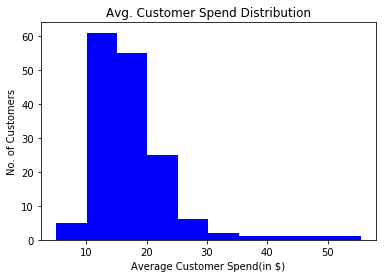

SID 7B8E9E45F5 spends $ 11.55 per shipment on average. Their peers spend $ 15.0 on average.
SID 7B8E9E45F5 spends $ 11.55 per shipment on average. Their peers spend $ 15.0 on average.


In [61]:
#Replace raw_df here with the full_raw_df containing ALL records
full_sid_list = np.array(raw_df['business_sid'])
full_net_amount_list = np.array(raw_df['net_charge_amount'])

def KPI_avg_similar_customer_spend(sid):
    #Get list of all similar customers
    similar_customer_list = get_similar_customers(sid)
    
    #Get row indices of transactions for all similar customers in the raw_df
    similar_customers_idx = np.isin(full_sid_list, similar_customer_list)
    
    #The KPI denominator is the # of all transactions by similar customers
    KPI_denominator = len(similar_customers_idx.nonzero()[0])
    
    #The KPI numerator is the total sum of charges paid by similar customers
    KPI_numerator = np.sum(full_net_amount_list[similar_customers_idx])
    
    #Compute KPI
    KPI = KPI_numerator/KPI_denominator
    
    #Also, compute and return the avg. spend of the input sid
    input_sid_idx = np.isin(full_sid_list, sid)
    input_denominator = len(input_sid_idx.nonzero()[0])
    input_numerator = np.sum(full_net_amount_list[input_sid_idx])
    input_sid_avg_spend = input_numerator/input_denominator
    
    #Also, compute the avg. spend of each similar sid
    avg_spend_array = np.zeros(len(similar_customer_list))
    for i,j in enumerate(similar_customer_list):
        #print(i,j)
        sim_sid_idx = np.isin(full_sid_list,j)
        sim_sid_denom = len(sim_sid_idx.nonzero()[0])
        sim_sid_num = np.sum(full_net_amount_list[sim_sid_idx])
        avg_spend_array[i] = sim_sid_num/sim_sid_denom
        
    plt.hist(avg_spend_array,color = 'blue');
    plt.xlabel('Average Customer Spend(in $)')
    plt.ylabel('No. of Customers')
    plt.title('Avg. Customer Spend Distribution')
    plt.show();
        
    print('SID', sid, 'spends $', round(input_sid_avg_spend,2), 'per shipment on average. Their peers spend $',round(KPI,2), 'on average.')    
    return np.round([input_sid_avg_spend, KPI], 2)

test_sid = ref_sids[0]
KPI_avg_spend_values = KPI_avg_similar_customer_spend(test_sid)
print('SID', test_sid, 'spends $', KPI_avg_spend_values[0], 'per shipment on average. Their peers spend $',KPI_avg_spend_values[1], 'on average.')

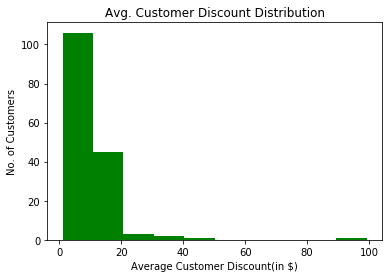

SID 924052DDF5 gets a discount of $ 7.27 per shipment on average. Their peers get $ 10.96 on average.
SID 924052DDF5 gets a discount of $ 7.27 per shipment on average. Their peers get $ 10.96 on average.


In [62]:
full_sid_list = np.array(raw_df['business_sid'])
#we need to take absolute values for the freight_discount_amount
full_discount_list = np.add(abs(np.array(raw_df['freight_discount_amount'])),\
                            np.array(raw_df['misc_discount_amount'])  )

def KPI_avg_discounts(sid):
    #Get list of all similar customers
    similar_customer_list = get_similar_customers(sid)
    
    #Get row indices of transactions for all similar customers in the raw_df
    similar_customers_idx = np.isin(full_sid_list, similar_customer_list)
    
    #The KPI denominator is the # of all transactions by similar customers
    KPI_denominator = len(similar_customers_idx.nonzero()[0])
    
    #The KPI numerator is the total sum of charges paid by similar customers
    KPI_numerator = np.sum(full_discount_list[similar_customers_idx])
    
    #Compute KPI
    KPI = KPI_numerator/KPI_denominator
    
    #Also, compute and return the avg. spend of the input sid
    input_sid_idx = np.isin(full_sid_list, sid)
    input_denominator = len(input_sid_idx.nonzero()[0])
    input_numerator = np.sum(full_discount_list[input_sid_idx])
    input_sid_avg_discount = input_numerator/input_denominator
    
    #Also, compute the avg. discount of each similar sid
    avg_discount_array = np.zeros(len(similar_customer_list))
    for i,j in enumerate(similar_customer_list):
        #print(i,j)
        sim_sid_idx = np.isin(full_sid_list,j)
        sim_sid_denom = len(sim_sid_idx.nonzero()[0])
        sim_sid_num = np.sum(full_discount_list[sim_sid_idx])
        avg_discount_array[i] = sim_sid_num/sim_sid_denom
        
    plt.hist(avg_discount_array,color = 'green');
    plt.xlabel('Average Customer Discount(in $)')
    plt.ylabel('No. of Customers')
    plt.title('Avg. Customer Discount Distribution')
    plt.show();
    
    print('SID', sid, 'gets a discount of $', round(input_sid_avg_discount,2), 'per shipment on average. Their peers get $',round(KPI,2), 'on average.')    
    return np.round([input_sid_avg_discount, KPI], 2)

test_sid = ref_sids[2]
KPI_avg_discount_values = KPI_avg_discounts(test_sid)
print('SID', test_sid, 'gets a discount of $', KPI_avg_discount_values[0], 'per shipment on average. Their peers get $',KPI_avg_discount_values[1], 'on average.')

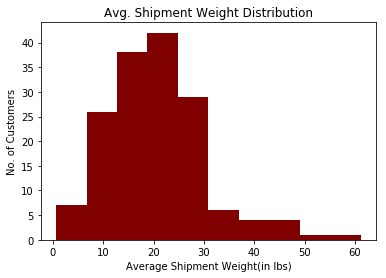

SID 924052DDF5 has an avg shipment weight of  24.74 lbs. Their peers have an avg. shipment weight of 18.05 lbs
SID 924052DDF5 has an avg shipment weight of  24.74 lbs. Their peers have an avg. shipment weight of 18.05 lbs


In [65]:
#full_sid_list = np.array(raw_df['business_sid'])
full_weight_list = np.array(raw_df['weight'])

def KPI_avg_weights(sid):
    #Get list of all similar customers
    similar_customer_list = get_similar_customers(sid)
    
    #Get row indices of transactions for all similar customers in the raw_df
    similar_customers_idx = np.isin(full_sid_list, similar_customer_list)
    
    #The KPI denominator is the # of all transactions by similar customers
    KPI_denominator = len(similar_customers_idx.nonzero()[0])
    
    #The KPI numerator is the total sum of charges paid by similar customers
    KPI_numerator = np.sum(full_weight_list[similar_customers_idx])
    
    #Compute KPI
    KPI = KPI_numerator/KPI_denominator
    
    #Also, compute and return the avg. weight of the input sid
    input_sid_idx = np.isin(full_sid_list, sid)
    input_denominator = len(input_sid_idx.nonzero()[0])
    input_numerator = np.sum(full_weight_list[input_sid_idx])
    input_sid_avg_discount = input_numerator/input_denominator
    
    #Also, compute the avg. discount of each similar sid
    avg_weight_array = np.zeros(len(similar_customer_list))
    for i,j in enumerate(similar_customer_list):
        #print(i,j)
        sim_sid_idx = np.isin(full_sid_list,j)
        sim_sid_denom = len(sim_sid_idx.nonzero()[0])
        sim_sid_num = np.sum(full_weight_list[sim_sid_idx])
        avg_weight_array[i] = sim_sid_num/sim_sid_denom
        
    plt.hist(avg_weight_array,color = 'maroon');
    plt.xlabel('Average Shipment Weight(in lbs)')
    plt.ylabel('No. of Customers')
    plt.title('Avg. Shipment Weight Distribution')
    plt.show();
    
    print('SID',sid, 'has an avg shipment weight of ', round(input_sid_avg_discount,2), 'lbs. Their peers have an avg. shipment weight of',round(KPI,2), 'lbs')    
    return np.round([input_sid_avg_discount, KPI], 2)

test_sid = ref_sids[2]
KPI_avg_weight_values = KPI_avg_weights(test_sid)
print('SID', test_sid, 'has an avg shipment weight of ', KPI_avg_weight_values[0], 'lbs. Their peers have an avg. shipment weight of',KPI_avg_weight_values[1], 'lbs')

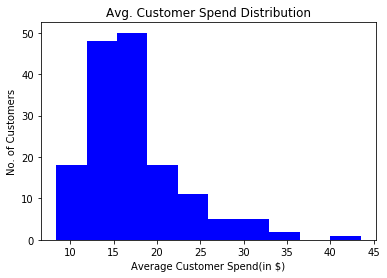

SID E0518749DD spends $ 15.84 per shipment on average. Their peers spend $ 15.43 on average.


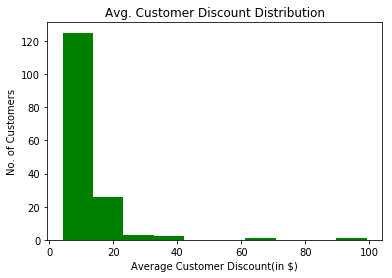

SID E0518749DD gets a discount of $ 17.92 per shipment on average. Their peers get $ 12.11 on average.


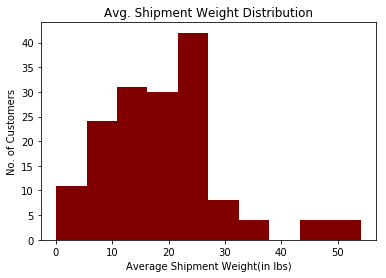

SID E0518749DD has an avg shipment weight of  12.4 lbs. Their peers have an avg. shipment weight of 14.66 lbs


In [67]:
def calculate_all_KPIs(sid):
    KPI_avg_similar_customer_spend(sid)
    KPI_avg_discounts(sid)
    KPI_avg_weights(sid)
    
test_sid = ref_sids[1]    
calculate_all_KPIs(test_sid)